# Stage 1: Physics-Informed Hybrid Liquid Neural Network (PI-HLNN)
## LOS / NLOS Classification from Raw CIR

**Architecture**: Pure Liquid Neural Network with input+state driven time constants (tau).
**Physics-Informed**: RXPACC normalization, ODE dynamics, tau via `softplus` (no hardcoded targets).
**Hybrid**: Combines physics priors (preprocessing, loss, ODE structure) with data-driven learned dynamics.
**Input**: Raw 60-sample CIR window â€” no hand-crafted features. The LNN learns temporal dynamics directly from the signal.
**Training**: `combined_uwb_dataset.csv` (3600 samples, 6 UWB channels), 70/15/15 train/val/test split.
**Pipeline**: **Stage 1 (LNN â†’ LOS/NLOS)** â†’ Stage 2 (MLP â†’ single/multi bounce) â†’ Stage 3 (MLP â†’ ranging error)

In [ ]:
CONFIG = {
    "pre_crop": 10,
    "post_crop": 50,
    "total_len": 60,
    "search_start": 740,
    "search_end": 890,
    "hidden_size": 64,
    "input_size": 1,
    "dropout": 0.2,
    "ode_unfolds": 6,
    "batch_size": 64,
    "max_epochs": 40,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "warmup_epochs": 3,
    "patience": 10,
    "grad_clip": 1.0,
    "val_ratio": 0.15,
    "test_ratio": 0.15,
    "seed": 42,
}

---
## Section 2: Data Loading, ROI Alignment & 70/15/15 Split

**ROI search range**: `[740, 890]` â€” derived from empirical CIR peak analysis:
- All CIR peaks across 36 CSV files (LOS + NLOS, 6 channels) fall within indices **743â€“807**.
- `search_start=740`: 3 indices before the earliest observed peak (743), provides margin.
- `search_end=890`: ~80 indices past the latest observed peak (807), captures any multipath tail.
- Noise floor estimated from indices 0â€“739 (740 samples of pure noise = robust estimate).

In [2]:
# ==========================================
# SMART ROI ALIGNMENT
# ==========================================
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    """
    Find the leading edge of the pulse by backtracking from peak.
    Uses noise floor estimation (mean + 3*std) or 5% of peak.

    Search range [740, 890] derived from empirical CIR peak analysis:
      - All peaks across 36 files fall within indices 743-807
      - 740 start = margin before earliest peak
      - 890 end = margin past latest multipath outlier
    """
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)

    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]

    # Noise floor from samples before the search region
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val

    # Backtrack from peak to find leading edge
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break

    return leading_edge


# ==========================================
# DATASET LOADER (CIR-ONLY)
# ==========================================
def load_cir_dataset(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """
    Load and preprocess CIR data. Returns only the CIR sequence and labels.
    No hand-crafted features â€” the LNN learns directly from the signal.
    """
    PRE = CONFIG["pre_crop"]
    POST = CONFIG["post_crop"]
    TOTAL = CONFIG["total_len"]

    processed_seqs = []
    labels = []

    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )
    print(f"  Samples: {len(df)}, CIR columns: {len(cir_cols)}")

    for _, row in df.iterrows():
        # 1. Parse raw signal
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values

        # 2. PHYSICS NORMALIZATION: divide by RXPACC
        rxpacc_col = 'RXPACC' if 'RXPACC' in row.index else 'RX_PACC'
        rxpacc = float(row.get(rxpacc_col, 128.0))
        if rxpacc > 0:
            sig = sig / rxpacc

        # 3. Smart ROI alignment
        leading_edge = get_roi_alignment(sig)

        # 4. Crop around leading edge
        start = max(0, leading_edge - PRE)
        end = start + TOTAL
        if end > len(sig):
            end = len(sig)
            start = max(0, end - TOTAL)

        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')

        # 5. Instance normalization [0, 1]
        local_min = np.min(crop)
        local_max = np.max(crop)
        rng = local_max - local_min
        if rng > 0:
            crop = (crop - local_min) / rng
        else:
            crop = np.zeros(TOTAL)

        processed_seqs.append(crop)
        labels.append(float(row['Label']))

    X = np.array(processed_seqs).reshape(-1, TOTAL, 1).astype(np.float32)
    y = np.array(labels).astype(np.float32)

    print(f"  Output shape: X={X.shape}, y={y.shape}")
    print(f"  LOS: {int(np.sum(y == 0))}, NLOS: {int(np.sum(y == 1))}")
    return X, y


# Load and split 70/15/15
X_all, y_all = load_cir_dataset("../dataset/channels/combined_uwb_dataset.csv")

# 70/15/15 stratified split
val_ratio = CONFIG["val_ratio"]
test_ratio = CONFIG["test_ratio"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all,
    test_size=val_ratio + test_ratio,
    stratify=y_all,
    random_state=CONFIG["seed"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=test_ratio / (val_ratio + test_ratio),
    stratify=y_temp,
    random_state=CONFIG["seed"]
)

print(f"\nSplit (70/15/15):")
print(f"  Train: {X_train.shape[0]} (LOS: {int(np.sum(y_train==0))}, NLOS: {int(np.sum(y_train==1))})")
print(f"  Val:   {X_val.shape[0]} (LOS: {int(np.sum(y_val==0))}, NLOS: {int(np.sum(y_val==1))})")
print(f"  Test:  {X_test.shape[0]} (LOS: {int(np.sum(y_test==0))}, NLOS: {int(np.sum(y_test==1))})")

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Samples: 3600, CIR columns: 1016
  Output shape: X=(3600, 60, 1), y=(3600,)
  LOS: 1800, NLOS: 1800

Split (70/15/15):
  Train: 2520 (LOS: 1260, NLOS: 1260)
  Val:   540 (LOS: 270, NLOS: 270)
  Test:  540 (LOS: 270, NLOS: 270)


---
## Section 3: Model Architecture â€” PI-HLNN

### Key Design: Input + State Driven Tau

The time constant $\tau_t$ at each timestep is controlled by both the current CIR sample $x_t$ and the hidden state $h_t$:

$$\tau_t = \Delta t + \text{softplus}\big(f_\tau([x_t, h_t])\big)$$

where $\text{softplus}(z) = \ln(1 + e^z)$.

**Justification for the tau formulation:**
- **No upper bound** â€” the network learns the appropriate time scale from data.
- **Lower bound = $\Delta t$** â€” this is the Euler discretization step. The ratio $\Delta t / \tau$ appears in the ODE denominator; keeping $\tau \geq \Delta t$ ensures this ratio stays $\leq 1$, which is required for stable Euler integration.
- **Softplus** â€” smooth, always-positive activation that allows unconstrained gradient flow (unlike sigmoid which saturates).

The ODE update (Euler discretization):

$$h_{t+1} = \frac{h_t + \Delta t \cdot S_t \cdot A}{1 + \Delta t / \tau_t}$$

Where $S_t = \tanh(W_s \cdot [x_t, h_t])$ is the synaptic activation and $A$ is a learnable decay parameter.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PILiquidCell(nn.Module):
    """
    Conductance-based LTC cell (Hasani et al. 2020).
    - Recurrent synapses: full conductance with reversal potentials
    - Sensory synapses: gated additive input (direct injection)
    - Softplus on conductances only (gleak, cm, w, sensory_w)
    - ODE solved via semi-implicit Euler
    """
    def __init__(self, input_size, hidden_size, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.ode_unfolds = ode_unfolds

        # Neuron intrinsic parameters
        self.gleak = nn.Parameter(torch.empty(hidden_size).uniform_(0.001, 1.0))
        self.vleak = nn.Parameter(torch.empty(hidden_size).uniform_(-0.2, 0.2))
        self.cm    = nn.Parameter(torch.empty(hidden_size).uniform_(0.4, 0.6))

        # Recurrent synapses (conductance-based, h x h)
        self.w     = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.001, 1.0))
        self.erev  = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(-0.2, 0.2))
        self.mu    = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.3, 0.8))
        self.sigma = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(3, 8))

        # Sensory synapses (gated input, input x h)
        self.sensory_w     = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.001, 1.0))
        self.sensory_mu    = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.3, 0.8))
        self.sensory_sigma = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(3, 8))

    def forward(self, x_t, h_prev, dt=1.0):
        # Positivity via softplus — conductances only (NOT sigma)
        gleak = F.softplus(self.gleak)
        cm    = F.softplus(self.cm)
        w     = F.softplus(self.w)
        sensory_w = F.softplus(self.sensory_w)

        # Sensory current — gated additive input (computed once)
        sensory_gate = torch.sigmoid(
            self.sensory_sigma * (x_t.unsqueeze(-1) - self.sensory_mu)
        )  # (batch, input, hidden)
        sensory_current = (sensory_w * sensory_gate * x_t.unsqueeze(-1)).sum(dim=1)

        # Semi-implicit Euler ODE integration
        cm_t = cm / (dt / self.ode_unfolds)
        v = h_prev

        for _ in range(self.ode_unfolds):
            recurrent_gate = torch.sigmoid(
                self.sigma.unsqueeze(0) * (v.unsqueeze(2) - self.mu.unsqueeze(0))
            )
            w_gate = w.unsqueeze(0) * recurrent_gate
            w_num = (w_gate * self.erev.unsqueeze(0)).sum(dim=1)
            w_den = w_gate.sum(dim=1)

            numerator   = cm_t * v + gleak * self.vleak + w_num + sensory_current
            denominator = cm_t + gleak + w_den + 1e-8
            v = numerator / denominator

        tau = cm / (gleak + w_den + 1e-8)
        return v, tau


class PI_HLNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, dropout=0.4, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = PILiquidCell(input_size, hidden_size, ode_unfolds)
        self.attn = nn.Linear(hidden_size, 1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, return_dynamics=False):
        batch_size, seq_len, _ = x_seq.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
        h_states = []
        tau_sum = torch.zeros_like(h_t)
        tau_history = []
        for t in range(seq_len):
            h_t, tau_t = self.cell(x_seq[:, t, :], h_t)
            h_states.append(h_t.unsqueeze(1))
            tau_sum += tau_t
            if return_dynamics:
                tau_history.append(tau_t.unsqueeze(1))
        h_all = torch.cat(h_states, dim=1)
        attn_scores = self.attn(h_all).squeeze(-1)
        attn_weights = F.softmax(attn_scores, dim=1).unsqueeze(-1)
        h_pooled = (h_all * attn_weights).sum(dim=1)
        tau_mean = tau_sum / seq_len
        prediction = self.classifier(h_pooled)
        if return_dynamics:
            tau_hist = torch.cat(tau_history, dim=1)
            return prediction, h_all, tau_hist, tau_mean
        return prediction, tau_mean


# Quick param count
test_model = PI_HLNN(input_size=1, hidden_size=64, ode_unfolds=6)
total_params = sum(p.numel() for p in test_model.parameters())
print(f"PI-HLNN parameter count: {total_params:,}")
print(f"  Recurrent (w, erev, mu, sigma): {4 * 64 * 64:,}")
print(f"  Sensory (w, mu, sigma):         {3 * 1 * 64:,}")
print(f"  Neuron (gleak, vleak, cm):      {3 * 64:,}")
print(f"  Attention:                      {64 + 1:,}")
print(f"  Classifier:                     {64*32+32 + 32*1+1:,}")
del test_model

---
## Section 4: Loss Function

$$\mathcal{L} = \mathcal{L}_{BCE}$$

Pure binary cross-entropy. The time constant $\tau$ is **not** constrained by the loss â€” it emerges entirely from the ODE dynamics driven by `[x_t, h_t]`. This lets the LNN discover its own temporal behavior from the signal.

The tau values are still computed and available for post-training diagnostics (tau distribution, temporal evolution).

In [4]:
# ==========================================
# LOSS FUNCTION (Pure BCE)
# ==========================================
criterion_fn = nn.BCELoss()

print("Loss: Binary Cross-Entropy (pure BCE, no tau constraint)")

Loss: Binary Cross-Entropy (pure BCE, no tau constraint)


---
## Section 5: Training Pipeline (70/15/15 Split)

In [ ]:
# ==========================================
# TRAINING PIPELINE (70/15/15)
# ==========================================
import math

def train_model(X_train, y_train, X_val, y_val, config=CONFIG):
    print(f"Training on {len(X_train)} samples, validating on {len(X_val)}")

    # Prepare tensors
    X_tr = torch.tensor(X_train).to(device)
    y_tr = torch.tensor(y_train).unsqueeze(1).to(device)
    X_va = torch.tensor(X_val).to(device)
    y_va = torch.tensor(y_val).unsqueeze(1).to(device)

    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

    # Initialize model
    model = PI_HLNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        dropout=config["dropout"],
        ode_unfolds=config.get("ode_unfolds", 6)
    ).to(device)

    criterion = nn.BCELoss()

    optimizer = optim.AdamW(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )

    # Warmup + Cosine Annealing scheduler
    warmup_epochs = config["warmup_epochs"]
    total_epochs = config["max_epochs"]

    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
        return max(0.01, 0.5 * (1.0 + math.cos(math.pi * progress)))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    # Training history
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "lr": []
    }

    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(config["max_epochs"]):
        # --- TRAIN ---
        model.train()
        train_loss_sum = 0
        train_correct, train_total = 0, 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred, tau_mean = model(batch_x)
            loss = criterion(pred, batch_y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
            optimizer.step()

            train_loss_sum += loss.item() * len(batch_x)
            train_correct += ((pred > 0.5).float() == batch_y).sum().item()
            train_total += len(batch_x)

        train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total

        # --- VALIDATE ---
        model.eval()
        with torch.no_grad():
            val_pred, val_tau = model(X_va)
            val_loss = criterion(val_pred, y_va)
            val_acc = ((val_pred > 0.5).float() == y_va).float().mean().item()

        lr_now = optimizer.param_groups[0]['lr']

        # Record history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss.item())
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["lr"].append(lr_now)

        scheduler.step()

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 5 == 0 or epoch == config["max_epochs"] - 1:
            print(f"  Ep {epoch:>3} | Loss: {train_loss:.4f} | "
                  f"Val Acc: {100*val_acc:.2f}% | "
                  f"Best: {100*best_val_acc:.2f}% | LR: {lr_now:.1e}")

        if patience_counter >= config["patience"]:
            print(f"  Early stopping at epoch {epoch} (patience={config['patience']})")
            break

    # Load best model
    model.load_state_dict(best_model_state)
    print(f"\nBest Validation Accuracy: {100*best_val_acc:.2f}%")

    return model, (X_va, y_va), history


# Run training
best_model, best_data, best_history = train_model(X_train, y_train, X_val, y_val)

---
## Section 6: Diagnostics

In [ ]:
# ==========================================
# DIAGNOSTIC GRID (3x2)
# ==========================================
def plot_diagnostics(model, val_data, history):
    X_va, y_va = val_data
    model.eval()
    
    with torch.no_grad():
        preds, h_hist, tau_hist, tau_mean = model(X_va, return_dynamics=True)
    
    y_true = y_va.cpu().numpy().flatten()
    y_prob = preds.cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(float)
    tau_mean_np = tau_mean.cpu().numpy().mean(axis=1)  # (batch,)
    h_hist_np = h_hist.cpu().numpy()
    tau_hist_np = tau_hist.cpu().numpy()
    
    fig, axs = plt.subplots(2, 3, figsize=(24, 14))
    plt.subplots_adjust(hspace=0.35, wspace=0.3)
    
    # --- 1. LEARNING CURVES ---
    ax = axs[0, 0]
    ax.plot(history["train_loss"], label='Train Loss', color='#3498db', lw=2)
    ax.plot(history["val_loss"], label='Val Loss', color='#e74c3c', lw=2, ls='--')
    ax.set_title("Learning Curves")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss (BCE)")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # --- 2. ACCURACY CURVES ---
    ax = axs[0, 1]
    ax.plot(history["train_acc"], label='Train Acc', color='#3498db', lw=2)
    ax.plot(history["val_acc"], label='Val Acc', color='#e74c3c', lw=2, ls='--')
    ax.set_title("Accuracy Curves")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0.4, 1.05])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # --- 3. CONFUSION MATRIX ---
    ax = axs[0, 2]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['LOS', 'NLOS'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    acc = (y_true == y_pred).mean()
    ax.set_title(f"Confusion Matrix (Acc: {100*acc:.1f}%)")
    
    # --- 4. ROC CURVE ---
    ax = axs[1, 0]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'AUC = {roc_auc:.4f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
    ax.set_title("ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # --- 5. PCA PHASE SPACE ---
    ax = axs[1, 1]
    batch_size, seq_len, hidden_dim = h_hist_np.shape
    
    los_idx = np.where(y_true == 0)[0]
    nlos_idx = np.where(y_true == 1)[0]
    n_show = min(len(los_idx), len(nlos_idx), 25)
    show_idx = np.concatenate([los_idx[:n_show], nlos_idx[:n_show]])
    
    h_flat = h_hist_np.reshape(-1, hidden_dim)
    pca = PCA(n_components=2)
    h_pca = pca.fit_transform(h_flat).reshape(batch_size, seq_len, 2)
    
    for i in show_idx:
        color = '#2ecc71' if y_true[i] == 0 else '#e74c3c'
        ax.plot(h_pca[i, :, 0], h_pca[i, :, 1], color=color, alpha=0.3, lw=0.8)
        ax.scatter(h_pca[i, -1, 0], h_pca[i, -1, 1], color=color, s=15, zorder=5)
    
    ax.set_title(f"Liquid State Phase Space (PCA, n={n_show*2})")
    ax.set_xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)")
    ax.set_ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)")
    ax.grid(True, alpha=0.2)
    
    # --- 6. TAU DISTRIBUTION (emergent, no targets) ---
    ax = axs[1, 2]
    sns.kdeplot(tau_mean_np[y_true == 0], ax=ax, fill=True, color='#2ecc71',
                label=f'LOS (mean={tau_mean_np[y_true==0].mean():.2f})', alpha=0.6)
    sns.kdeplot(tau_mean_np[y_true == 1], ax=ax, fill=True, color='#e74c3c',
                label=f'NLOS (mean={tau_mean_np[y_true==1].mean():.2f})', alpha=0.6)
    ax.set_title("Emergent Time Constants (Tau)")
    ax.set_xlabel("Mean Tau")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle("PI-HLNN Stage 1 Diagnostics", fontsize=16, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


plot_diagnostics(best_model, best_data, best_history)

In [ ]:
# ==========================================
# TAU TEMPORAL EVOLUTION
# ==========================================
def plot_tau_temporal(model, val_data, n_samples=5):
    """
    Show how tau evolves across the 60 timesteps for individual samples.
    This reveals the real-time adaptation of dynamics to the signal shape.
    """
    X_va, y_va = val_data
    model.eval()
    
    with torch.no_grad():
        _, _, tau_hist, _ = model(X_va, return_dynamics=True)
    
    y_true = y_va.cpu().numpy().flatten()
    tau_hist_np = tau_hist.cpu().numpy()  # (batch, seq_len, hidden)
    # Average across neurons for each timestep
    tau_temporal = tau_hist_np.mean(axis=2)  # (batch, seq_len)
    x_input = X_va.cpu().numpy().squeeze(-1)  # (batch, seq_len)
    
    los_idx = np.where(y_true == 0)[0][:n_samples]
    nlos_idx = np.where(y_true == 1)[0][:n_samples]
    
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))
    plt.subplots_adjust(hspace=0.35)
    
    # --- LOS: Signal + Tau ---
    ax = axs[0, 0]
    for i in los_idx:
        ax.plot(x_input[i], alpha=0.5, color='#2ecc71', lw=1.2)
    ax.set_title(f"LOS Signals (n={len(los_idx)})")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Normalized CIR")
    ax.grid(True, alpha=0.3)
    
    ax = axs[0, 1]
    for i in los_idx:
        ax.plot(tau_temporal[i], alpha=0.5, color='#2ecc71', lw=1.2)
    ax.set_title(f"LOS Tau Evolution")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Mean Tau")
    ax.set_ylim([0.5, 6.5])
    ax.grid(True, alpha=0.3)
    
    # --- NLOS: Signal + Tau ---
    ax = axs[1, 0]
    for i in nlos_idx:
        ax.plot(x_input[i], alpha=0.5, color='#e74c3c', lw=1.2)
    ax.set_title(f"NLOS Signals (n={len(nlos_idx)})")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Normalized CIR")
    ax.grid(True, alpha=0.3)
    
    ax = axs[1, 1]
    for i in nlos_idx:
        ax.plot(tau_temporal[i], alpha=0.5, color='#e74c3c', lw=1.2)
    ax.set_title(f"NLOS Tau Evolution")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Mean Tau")
    ax.set_ylim([0.5, 6.5])
    ax.grid(True, alpha=0.3)
    
    plt.suptitle("Tau Temporal Evolution: How Dynamics Adapt to Signal Shape",
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()


plot_tau_temporal(best_model, best_data, n_samples=5)

---
## Section 7: Test Set Evaluation & Save Artifacts

Test Accuracy: 96.11%

Classification Report:
              precision    recall  f1-score   support

         LOS       0.94      0.98      0.96       270
        NLOS       0.98      0.94      0.96       270

    accuracy                           0.96       540
   macro avg       0.96      0.96      0.96       540
weighted avg       0.96      0.96      0.96       540



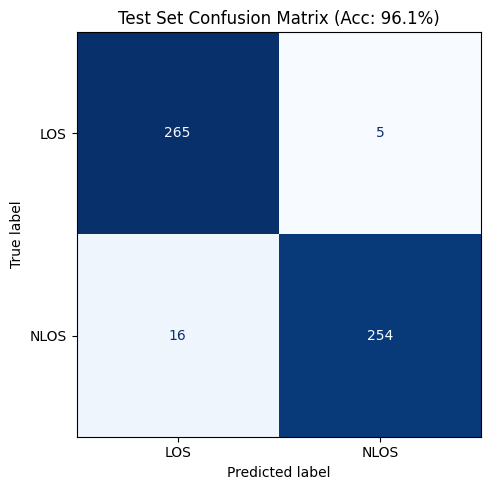

In [8]:
# ==========================================
# TEST SET EVALUATION
# ==========================================
best_model.eval()
X_te = torch.tensor(X_test).to(device)
y_te = torch.tensor(y_test).unsqueeze(1).to(device)

with torch.no_grad():
    test_pred, _ = best_model(X_te)
    test_acc = ((test_pred > 0.5).float() == y_te).float().mean().item()
    test_pred_np = (test_pred.cpu().numpy().flatten() > 0.5).astype(float)
    test_true_np = y_test.flatten()

print(f"Test Accuracy: {100*test_acc:.2f}%")
print(f"\nClassification Report:")
print(classification_report(test_true_np, test_pred_np, target_names=['LOS', 'NLOS']))

# Test confusion matrix
cm = confusion_matrix(test_true_np, test_pred_np)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=['LOS', 'NLOS'])
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f"Test Set Confusion Matrix (Acc: {100*test_acc:.1f}%)")
plt.tight_layout()
plt.show()

In [9]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
# 1. Model weights
torch.save(best_model.state_dict(), "stage1_pi_hlnn_best.pt")
print("Saved: stage1_pi_hlnn_best.pt")

# 2. Configuration (for reproducibility)
torch.save({"config": CONFIG}, "stage1_config.pt")
print("Saved: stage1_config.pt")

print(f"\nArtifacts ready for Stage 2.")

Saved: stage1_pi_hlnn_best.pt
Saved: stage1_config.pt

Artifacts ready for Stage 2.


In [10]:
print("Stage 1 complete.")
print("Model artifact: stage1_pi_hlnn_best.pt")
print("Config artifact: stage1_config.pt")
print("\nReady for Stage 2.")

Stage 1 complete.
Model artifact: stage1_pi_hlnn_best.pt
Config artifact: stage1_config.pt

Ready for Stage 2.
